In [16]:
!pip install numpy pandas matplotlib pillow tqdm torch torchvision scikit-learn tensorflow


In [17]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
image_path="./rps-cv-images"

#### removing corrupted_images
for category in os.listdir(folder_path):

*  It loops through each subfolder in the main folder (e.g., rock, paper, scissors).

for img_file in os.listdir(category_path):

*  It then loops through every image in that subfolder.

img = Image.open(img_path)

*  Tries to open the image using Pillow (PIL). This checks if the image can be read.

img.verify()

*  This verifies the image is not corrupted or partially downloaded. It does not load the image into memory (it’s lightweight).

If it fails (IOError or SyntaxError)

*   That means the image is likely corrupted (damaged file, wrong format, etc.).

*   It prints the path of the bad image and deletes it using os.remove(img_path).

In [19]:
def remove_corrupted_images(image_path):
    for category in os.listdir(image_path):
        category_path = os.path.join(image_path, category)
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print("Removing corrupted image:", img_path)
                os.remove(img_path)


In [20]:
remove_corrupted_images("rps-cv-images")

#### Loading the data 
Load all the images (rock, paper, scissors) from folders, resize them to 64×64 pixels, normalize their pixel values, automatically assign labels based on folder names, and split them into training and validation sets.
rescale=1./255 → Scales image pixel values from range [0, 255] to [0, 1] (which helps the neural network train better).
validation_split=0.2 → Splits your dataset: 80% for training, 20% for validation
##### loading the training data 
'rps-cv-images' → Path to the main folder that contains the rock/, paper/, and scissors/ folders.
target_size=(64, 64) → Resizes all images to 64×64 pixels.
batch_size=32 → Loads 32 images at a time (good for memory efficiency).
class_mode='categorical' → Labels are one-hot encoded. So if the classes are rock, paper, scissors, each image label looks like:

Rock → [1, 0, 0]

Paper → [0, 1, 0]

Scissors → [0, 0, 1]
subset='training' → This line tells it to use 80% of the data for training (from the split defined above).

##### loading the validation data 
It uses the remaining 20% of images (subset='validation').

In [21]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    image_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical",
    subset="training",
)

val_generator = datagen.flow_from_directory(
    image_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [22]:
src = 'rps-cv-images'
dst = 'rps-split'
splits = ['train', 'val', 'test']

for label in os.listdir(src):
    files = os.listdir(os.path.join(src, label))
    train, temp = train_test_split(files, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    
    for split, split_list in zip(splits, [train, val, test]):
        os.makedirs(os.path.join(dst, split, label), exist_ok=True)
        for f in split_list:
            shutil.copy(
                os.path.join(src, label, f),
                os.path.join(dst, split, label, f)
            )


In [23]:
train_gen = datagen.flow_from_directory('rps-split/train', target_size=(64, 64), class_mode='categorical')
val_gen = datagen.flow_from_directory('rps-split/val', target_size=(64, 64), class_mode='categorical')
test_gen = datagen.flow_from_directory('rps-split/test', target_size=(64, 64), class_mode='categorical', shuffle=False)


Found 1531 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 329 images belonging to 3 classes.


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = 224
DATA_DIR = "rps-split"

In [25]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [26]:
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [27]:
class MulticlassClassifier(nn.Module):
    def __init__(self):
        super(MulticlassClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # 224x224 -> 112x112
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),  # 112x112 -> 56x56
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.model(x)


In [28]:
def train_model(optimizer_name):
    model = MulticlassClassifier().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "BatchGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)
    elif optimizer_name == "MiniBatchSGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == "Nesterov":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    elif optimizer_name == "AdaGrad":
        optimizer = optim.Adagrad(model.parameters(), lr=0.01)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accs, val_accs, f1_scores = [], [], []

    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            pred = y_hat.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        train_accs.append(train_acc)

        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                pred = y_hat.argmax(dim=1)
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
                correct += (pred == y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        val_accs.append(val_acc)

        f1 = f1_score(all_labels, all_preds, average='macro')
        f1_scores.append(f1)

        print(f"{optimizer_name} | Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | F1 Score: {f1:.4f}")

    return train_accs, val_accs, f1_scores

In [29]:
part1_opts = ["BatchGD", "MiniBatchSGD", "SGD"]
part2_opts = ["BatchGD", "Momentum", "Nesterov"]
part3_opts = ["AdaGrad", "RMSprop", "Adam"]

all_parts = {
    "Part-I": part1_opts,
    "Part-II": part2_opts,
    "Part-III": part3_opts
}


In [30]:
results = {}
for part, opts in all_parts.items():
    print(f"\n==================== {part} ====================")
    for opt in opts:
        train_accs, val_accs, f1_scores = train_model(opt)
        results[opt] = {"train": train_accs, "val": val_accs, "f1": f1_scores}



==================== Part-I ====================
BatchGD | Epoch 1/10 | Train Acc: 0.4481 | Val Acc: 0.4817 | F1 Score: 0.3883
BatchGD | Epoch 2/10 | Train Acc: 0.6479 | Val Acc: 0.6402 | F1 Score: 0.6048
BatchGD | Epoch 3/10 | Train Acc: 0.7551 | Val Acc: 0.7348 | F1 Score: 0.7144
BatchGD | Epoch 4/10 | Train Acc: 0.8256 | Val Acc: 0.8354 | F1 Score: 0.8356
BatchGD | Epoch 5/10 | Train Acc: 0.8452 | Val Acc: 0.8537 | F1 Score: 0.8523
BatchGD | Epoch 6/10 | Train Acc: 0.8850 | Val Acc: 0.8933 | F1 Score: 0.8938
BatchGD | Epoch 7/10 | Train Acc: 0.8922 | Val Acc: 0.9360 | F1 Score: 0.9364
BatchGD | Epoch 8/10 | Train Acc: 0.9170 | Val Acc: 0.9146 | F1 Score: 0.9134
BatchGD | Epoch 9/10 | Train Acc: 0.9216 | Val Acc: 0.9299 | F1 Score: 0.9296
BatchGD | Epoch 10/10 | Train Acc: 0.9491 | Val Acc: 0.8750 | F1 Score: 0.8755
MiniBatchSGD | Epoch 1/10 | Train Acc: 0.4598 | Val Acc: 0.6280 | F1 Score: 0.6233
MiniBatchSGD | Epoch 2/10 | Train Acc: 0.6786 | Val Acc: 0.7530 | F1 Score: 0.7582
Min

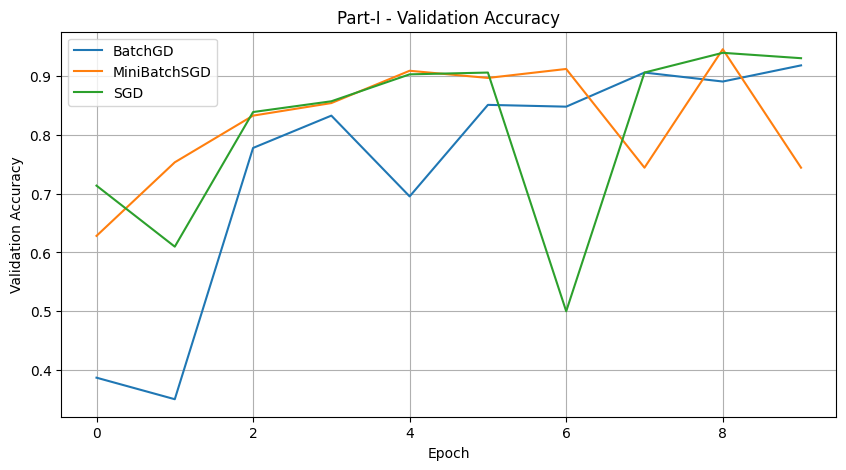

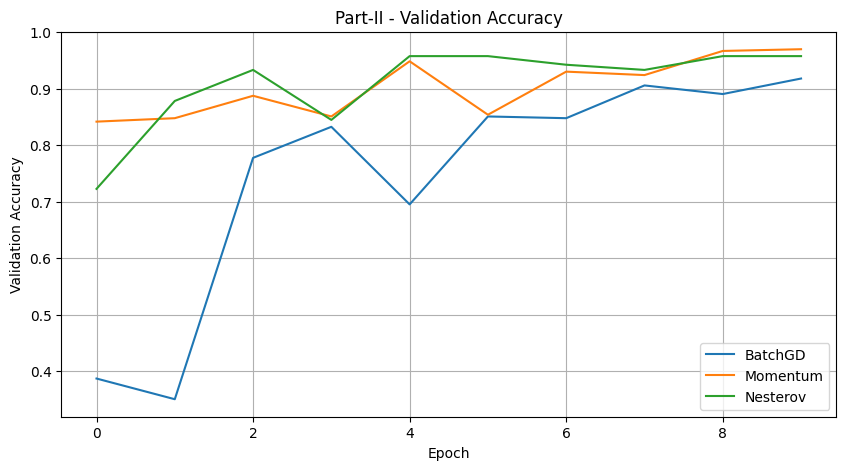

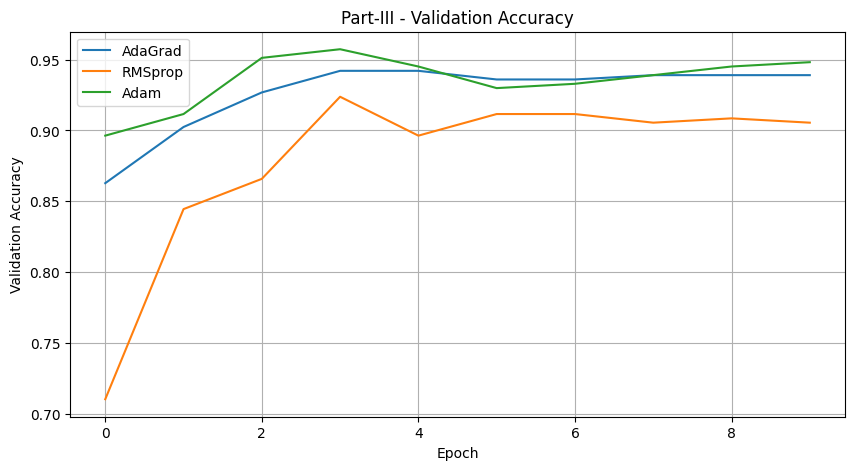

In [31]:
for part, opts in all_parts.items():
    plt.figure(figsize=(10, 5))
    for opt in opts:
        plt.plot(results[opt]["val"], label=opt)
    plt.title(f"{part} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

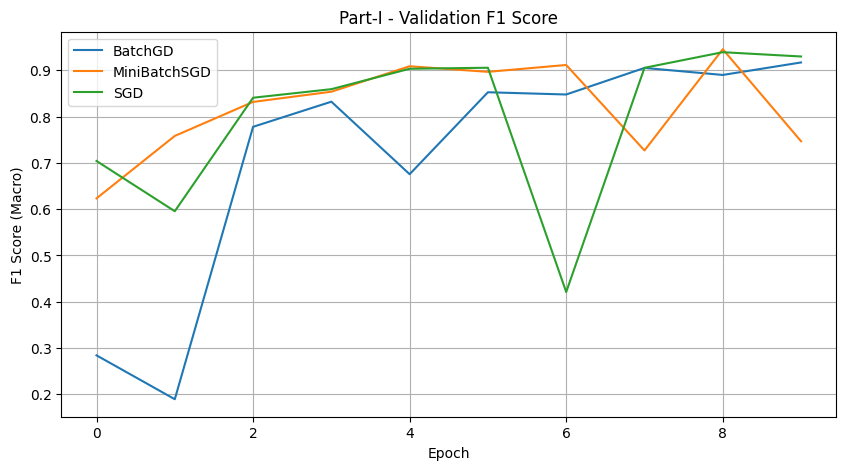

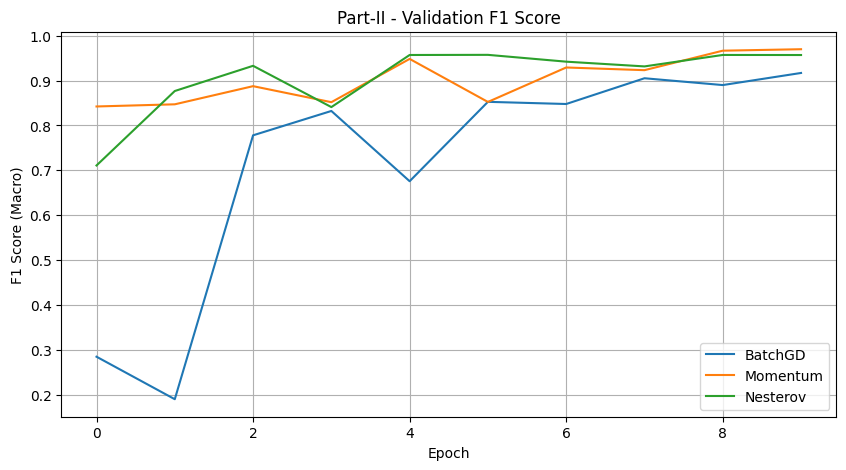

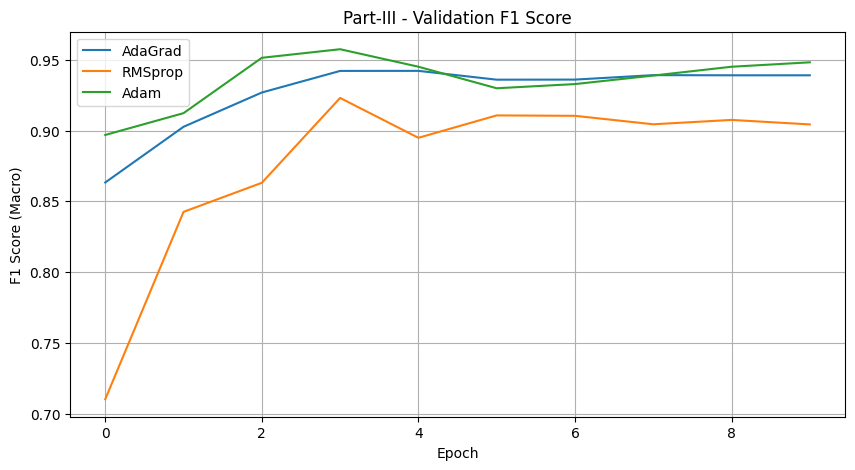

In [32]:
for part, opts in all_parts.items():
    plt.figure(figsize=(10, 5))
    for opt in opts:
        plt.plot(results[opt]["f1"], label=opt)
    plt.title(f"{part} - Validation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score (Macro)")
    plt.legend()
    plt.grid(True)
    plt.show()